In [10]:
from mech_module import *
from arima_functions import *

In [11]:
rivers = {'Brahmaputra, BD': 'DATA/2651100_Q_Day.Cmd.txt',
            'Tista, BD': 'DATA/2651080_Q_Day.Cmd.txt', 
            'Tadi Khola, NP': 'DATA/2549220_Q_Day.Cmd.txt',
            'Chepe Khola, NP': 'DATA/2549230_Q_Day.Cmd.txt',
            'Ganges, BD': 'DATA/2646200_Q_Day.Cmd.txt',
            'Chindwin, MM': 'DATA/2260100_Q_Day.Cmd.txt',
            'Irrawaddy, MM': 'DATA/2260400_Q_Day.Cmd.txt',
            'Sittang, MM': 'DATA/2261500_Q_Day.Cmd.txt',
            'Canagua, VZ': 'DATA/3206080_Q_Day.Cmd.txt',
            'Guapore, BR': 'DATA/3617814_Q_Day.Cmd.txt',
            'Pacaas Novos, BR': 'DATA/3617130_Q_Day.Cmd.txt',
            'KYMIJOKI, FI': 'DATA/6854203_Q_Day.Cmd.txt',
            'Bermeho, AR': 'DATA/3268900_Q_Day.Cmd.txt',} # for finland use only last 10 years (and manual slope)

widths = {
    'Brahmaputra, BD': 9310,
    'Tista, BD': 2200,
    'Tadi Khola, NP': 50,
    'Chepe Khola, NP': 50,
    'Ganges, BD': 1500,
    'Chindwin, MM': 500,
    'Irrawaddy, MM': 1200,
    'Sittang, MM': 130,
    'Canagua, VZ': 5,
    'Guapore, BR': 37,
    'Pacaas Novos, BR': 25,
    'KYMIJOKI, FI': 26,
    'Bermeho, AR': 50,
} # derived from google maps at the measurement station location


# Long term power prediction at a location

This notebook will combine the ARIMA time series forecasting at a location and the main power calculation. The output will be average daily power generation at a location for a year. This time series will be used to calculate minimum, maximum and average power as well as the total power.

1. Import data, fit ARIMA model and forecast power generation at a location

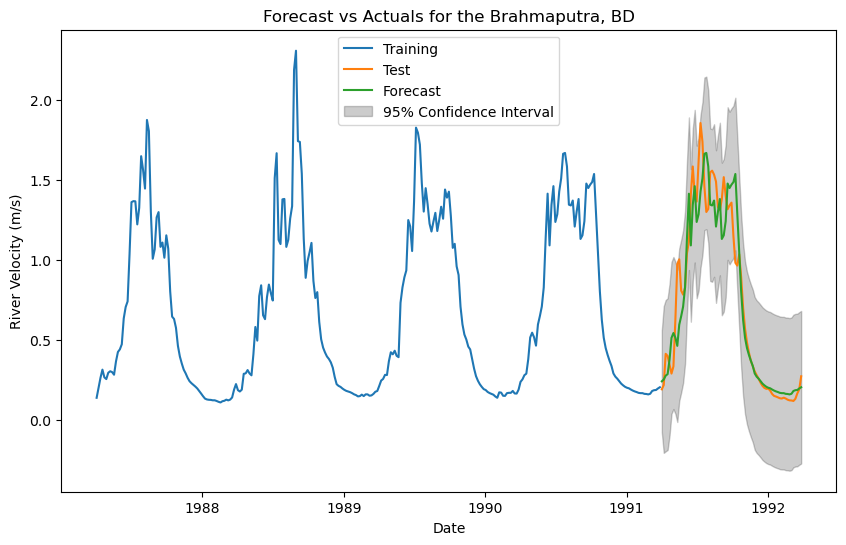

In [17]:
# using data from the ....
river = 'Brahmaputra, BD'
file_path = rivers[river]
metadata, data = read_data(file_path)
station_info, parsed_data = process_data(metadata, data)
# take the last 5 years of data if looking at location with over 5 years of data
if len(parsed_data) > 1825:
    parsed_data = parsed_data[-1825:]

lat1 = station_info['Latitude (DD)']
long1 = station_info['Longitude (DD)']

# slope = calc_slope(lat1, long1, 0.01)
slope = 0.01
Q = parsed_data['Value'].mean() # average discharge m^3/s
W = widths[river] # width in meters
S = slope # slope at location
D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters
parsed_data['Velocity'] = parsed_data['Value'] / (W * D) # velocity in m/s
parsed_data = downsample(parsed_data)
train, test = split_data(parsed_data, split=0.8)
model = arima_model(train, order=(3,0,2), seasonal_order=(0,1,0,73))
forecast_data, forecast_ci = forecast(model, test)
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
# also plot the arima confidence interval
# print(forecast_ci)
plt.fill_between(forecast_data.index, forecast_ci['lower Sampled'], forecast_ci['upper Sampled'], color='k', alpha=0.2, label='95% Confidence Interval')
plt.title('Forecast vs Actuals for the %s' % river)
plt.ylabel('River Velocity (m/s)')
plt.xlabel('Date')
plt.legend()
plt.show()

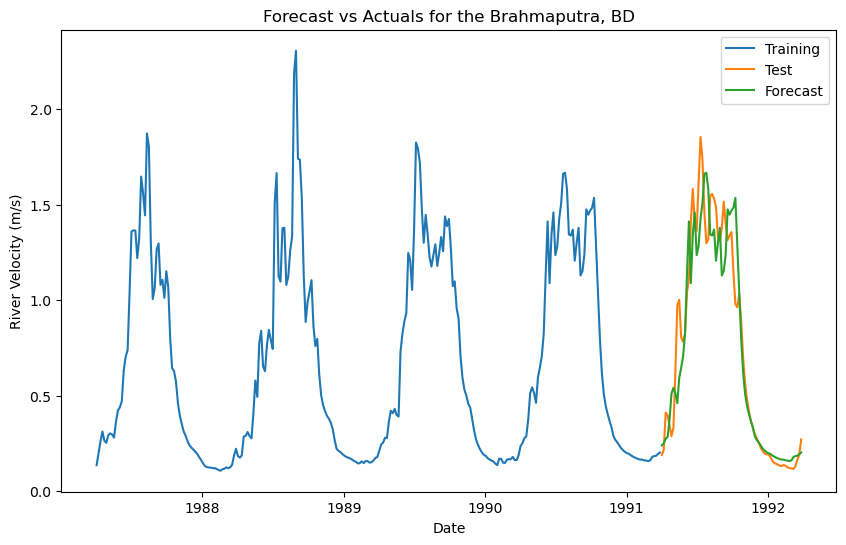

In [18]:
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.title('Forecast vs Actuals for the %s' % river)
plt.ylabel('River Velocity (m/s)')
plt.xlabel('Date')
plt.legend()
plt.show()

2. Calculate daily power generation at a location.

Need to upsample the time series to daily frequency and calculate average power generation at a location for a year.

--------------Average Power--------------
Average Power (W): 89.16438756228986
--------------Energy Output--------------
Daily Energy Output (kWh): 2.139945301494957
Monthly Energy Output (kWh): 64.1983590448487
Yearly Energy Output (kWh): 781.0800350456592
--------------Peak Season (P > 100W)--------------
Average Power (W) during peak season: 216.83490846743837
--------------Energy Output--------------
Daily Energy Output (kWh) during peak season: 5.204037803218521
Monthly Energy Output (kWh) during peak season: 156.1211340965556
--------------Low Season (P < 100W)--------------
Average Power (W) during low season: 11.994650481844522
--------------Energy Output--------------
Daily Energy Output (kWh) during low season: 0.2878716115642685
Monthly Energy Output (kWh) during low season: 8.636148346928056
--------------Comparison--------------
Average household per capita of around 497 kWh per year in BD (2021)


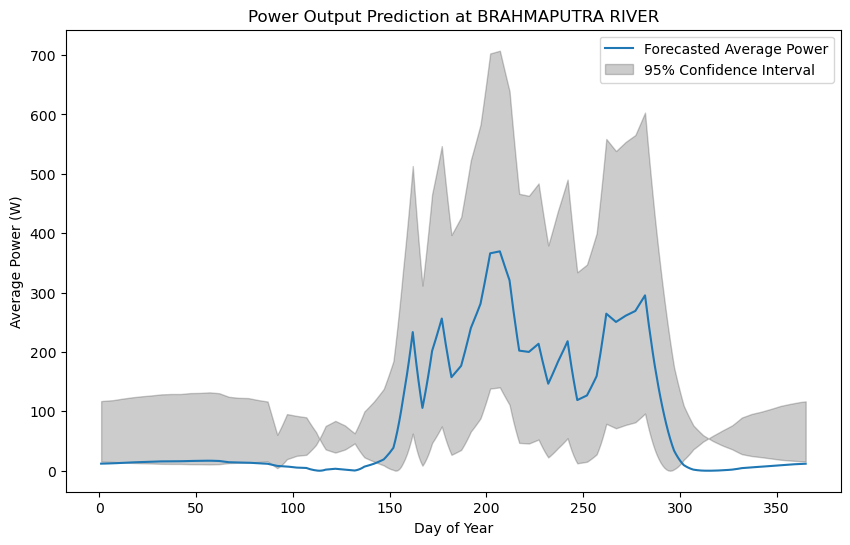

In [19]:
# upsample forecast data
full_forecast_data = forecast_data.resample('D').mean()
full_forecast_ci = forecast_ci.resample('D').mean()
full_forecast_data = full_forecast_data.interpolate(method='linear')
full_forecast_ci = full_forecast_ci.interpolate(method='linear')

# resample for day of year
full_forecast_data = full_forecast_data.groupby(full_forecast_data.index.dayofyear).mean()
full_forecast_ci = full_forecast_ci.groupby(full_forecast_ci.index.dayofyear).mean()

### calculate daily power output
# turbine parameters
turbine_width = 1.2
turbine_diameter = 1.2
r_drum = 0.425/2
pontoon_grid_multiplier = 1.05 # found in main.ipynb
generator_eff = 0.9
gearbox_eff = 0.95


# calculate power output
shaft_power = power(full_forecast_data * pontoon_grid_multiplier, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=20) * gearbox_eff * generator_eff
shaft_power_upper = power(full_forecast_ci['upper Sampled'] * pontoon_grid_multiplier, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=20) * gearbox_eff * generator_eff
shaft_power_lower = power(full_forecast_ci['lower Sampled'] * pontoon_grid_multiplier, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=20) * gearbox_eff * generator_eff

# plot power output
plt.figure(figsize=(10,6))
plt.plot(shaft_power, label='Forecasted Average Power')
plt.fill_between(shaft_power.index, shaft_power_upper, shaft_power_lower, color='k', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.title('Power Output Prediction at %s' %(station_info['River']))
plt.xlabel('Day of Year')
plt.ylabel('Average Power (W)')


# calculate the daily, monthly, and yearly energy output as the mean of the power output in that timeframe
# shaft power is given as avg W each day 
daily_energy = shaft_power.mean()*24/1000
monthly_energy = shaft_power.mean()*24*30/1000 
yearly_energy = shaft_power.mean()*24*365/1000

print('--------------Average Power--------------')
print(f"Average Power (W): {shaft_power.mean()}")
print('--------------Energy Output--------------')
print(f"Daily Energy Output (kWh): {daily_energy}")
print(f"Monthly Energy Output (kWh): {monthly_energy}")
print(f"Yearly Energy Output (kWh): {yearly_energy}")

# calculate the same values but during peak season (when p > 100W)
peak_season = shaft_power[shaft_power > 100]
daily_energy_peak = peak_season.mean()*24/1000
monthly_energy_peak = peak_season.mean()*24*30/1000
yearly_energy_peak = peak_season.mean()*24*365/1000

print('--------------Peak Season (P > 100W)--------------')
print(f"Average Power (W) during peak season: {peak_season.mean()}")
print('--------------Energy Output--------------')
print(f"Daily Energy Output (kWh) during peak season: {daily_energy_peak}")
print(f"Monthly Energy Output (kWh) during peak season: {monthly_energy_peak}")
# print(f"Yearly Energy Output (kWh) during peak season: {yearly_energy_peak}")

print('--------------Low Season (P < 100W)--------------')
print(f"Average Power (W) during low season: {shaft_power[shaft_power < 100].mean()}")
print('--------------Energy Output--------------')
print(f"Daily Energy Output (kWh) during low season: {shaft_power[shaft_power < 100].mean()*24/1000}")
print(f"Monthly Energy Output (kWh) during low season: {shaft_power[shaft_power < 100].mean()*24*30/1000}")

print('--------------Comparison--------------')
print('Average household per capita of around 497 kWh per year in BD (2021)') # https://www.enerdata.net/estore/energy-market/bangladesh/#:~:text=Energy%20consumption%20per%20capita%20is,average%20in%20the%20same%20period).


plt.show()



Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.


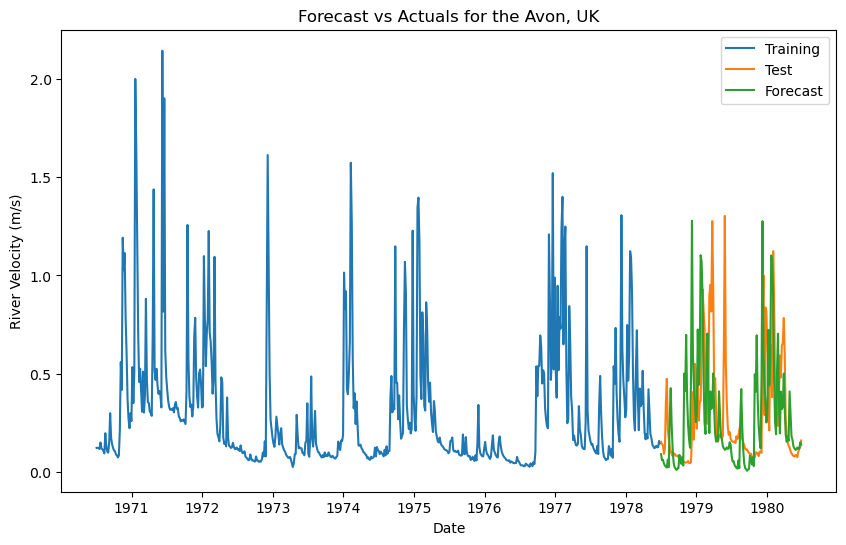

In [22]:
# uk river example
metadata, data = read_data_from_csv('DATA/53001_gdf.csv')
station_info, parsed_data = process_data_from_csv(metadata, data)
if len(parsed_data) > 8000:
    parsed_data = parsed_data[-3650:]

lat1 = station_info['Latitude (DD)']
long1 = station_info['Longitude (DD)']

slope = calc_slope(lat1, long1, 0.01)
Q = parsed_data['Value'].mean() # average discharge m^3/s
W = 8 # width in meters
S = slope # slope at location
D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters
parsed_data['Velocity'] = parsed_data['Value'] / (W * D) # velocity in m/s
parsed_data = downsample(parsed_data)
train, test = split_data(parsed_data, split=0.8)
model = arima_model(train, order=(2,0,2), seasonal_order=(0,1,0,73))
forecast_data = forecast(model, test)
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.title('Forecast vs Actuals for the %s' % 'Avon, UK')
plt.ylabel('River Velocity (m/s)')
plt.xlabel('Date')
plt.legend()
plt.show()

--------------Average Power--------------
Average Power (W): 52.912484938993344
--------------Energy Output--------------
Daily Energy Output (kWh): 1.2698996385358403
Monthly Energy Output (kWh): 38.09698915607521
Yearly Energy Output (kWh): 463.5133680655817
--------------Peak Season (P > 100W)--------------
Average Power (W) during peak season: nan
--------------Energy Output--------------
Daily Energy Output (kWh) during peak season: nan
Monthly Energy Output (kWh) during peak season: nan
--------------Comparison--------------
Average household per capita of around 497 kWh per year in BD (2021)


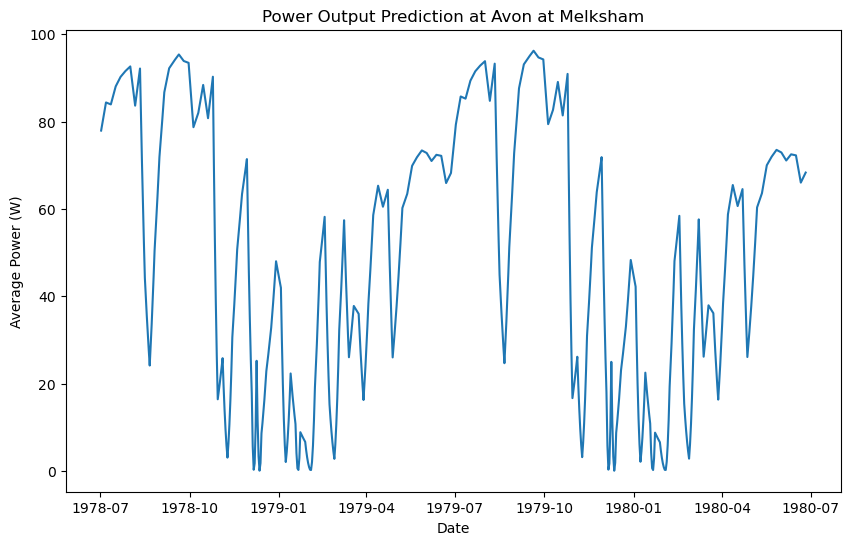

In [26]:
# upsample forecast data
full_forecast_data = forecast_data.resample('D').mean()
full_forecast_data = full_forecast_data.interpolate(method='linear')
### calculate daily power output
# turbine parameters
turbine_width = 1.2
turbine_diameter = 1.2
r_drum = 0.425
pontoon_grid_multiplier = 1.05 # found in main.ipynb
generator_eff = 0.9
gearbox_eff = 0.95
efficiency = generator_eff * gearbox_eff

# calculate power output
shaft_power = power(full_forecast_data * pontoon_grid_multiplier, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=20) * efficiency

# plot power output
plt.figure(figsize=(10,6))
plt.plot(shaft_power)
plt.title('Power Output Prediction at %s' %(station_info['River']))
plt.xlabel('Date')
plt.ylabel('Average Power (W)')


# calculate the daily, monthly, and yearly energy output as the mean of the power output in that timeframe
# shaft power is given as avg W each day 
daily_energy = shaft_power.mean()*24/1000
monthly_energy = shaft_power.mean()*24*30/1000 
yearly_energy = shaft_power.mean()*24*365/1000

print('--------------Average Power--------------')
print(f"Average Power (W): {shaft_power.mean()}")
print('--------------Energy Output--------------')
print(f"Daily Energy Output (kWh): {daily_energy}")
print(f"Monthly Energy Output (kWh): {monthly_energy}")
print(f"Yearly Energy Output (kWh): {yearly_energy}")

# calculate the same values but during peak season (when p > 100W)
peak_season = shaft_power[shaft_power > 100]
daily_energy_peak = peak_season.mean()*24/1000
monthly_energy_peak = peak_season.mean()*24*30/1000
yearly_energy_peak = peak_season.mean()*24*365/1000

print('--------------Peak Season (P > 100W)--------------')
print(f"Average Power (W) during peak season: {peak_season.mean()}")
print('--------------Energy Output--------------')
print(f"Daily Energy Output (kWh) during peak season: {daily_energy_peak}")
print(f"Monthly Energy Output (kWh) during peak season: {monthly_energy_peak}")
# print(f"Yearly Energy Output (kWh) during peak season: {yearly_energy_peak}")

print('--------------Comparison--------------')
print('Average household per capita of around 497 kWh per year in BD (2021)') # https://www.enerdata.net/estore/energy-market/bangladesh/#:~:text=Energy%20consumption%20per%20capita%20is,average%20in%20the%20same%20period).


plt.show()

